In [14]:
from LineageTrack.lineage_tracker import LineageTrack
from LineageTrack.visualiser import Visualiser
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image, display, HTML
from tqdm import tqdm
import pandas as pd
import seaborn as sns
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
directory = "/home/rl627/SSD1/SB8_30s_230224/FOV22/prop/"    # the example includes the first 13 trenches from Charlie's Phage experiment
exp = LineageTrack.from_path(directory)
print(exp)
display(exp.df.head(10))

Looking for data at these locations:
/home/rl627/SSD1/SB8_30s_230224/FOV22/prop/xy22_1.csv
Finished loading the data
(402629, 10)

                Read 1 files
                Channels: [1]
                Properties for each cell: ['1_intensity_mean', 'area', 'centroid-0', 'centroid-1', 'label', 'major_axis_length', 'minor_axis_length', 'orientation', 'time_(mins)', 'trench_id']
            


trench_id  time_(mins)  label  area  major_axis_length  minor_axis_length  \
0          0          0.5      1  2532         130.005554          26.086622   
1          0          0.5      2  2054         108.657288          24.631384   
2          0          0.5      3  2260         123.095016          24.244755   
3          0          0.5      4   757          39.283920          25.265936   
4          0          1.0      1  2567         131.342896          25.839556   
5          0          1.0      2  2117         111.725838          24.742102   
6          0          1.0      3  2268         123.906853          24.030521   
7          0          1.0      4   628          32.557610          25.244902   
8          0          1.5      1  2585         132.996613          25.664560   
9          0          1.5      2  2093         113.532806          24.448048   

   centroid-0  centroid-1  orientation  1_intensity_mean  
0   94.498421   35.906002     0.127461      14400.053711  
1  203.240021   38.610516     0.105132      17277.753906  
2  306.800873   42.090267     0.157094      19764.583984  
3  382.885071   40.055481     0.061725      20573.585938  
4   95.137123   35.310867     0.137385      14233.703125  
5  205.850266   38.365139     0.137690      17096.642578  
6  312.376099   42.982803     0.123707      20222.773438  
7  385.683136   40.186306     0.156489      20684.248047  
8   95.565186   33.649128    -0.037467      14257.156250  
9  206.759201   40.913998     0.007439      17580.626953

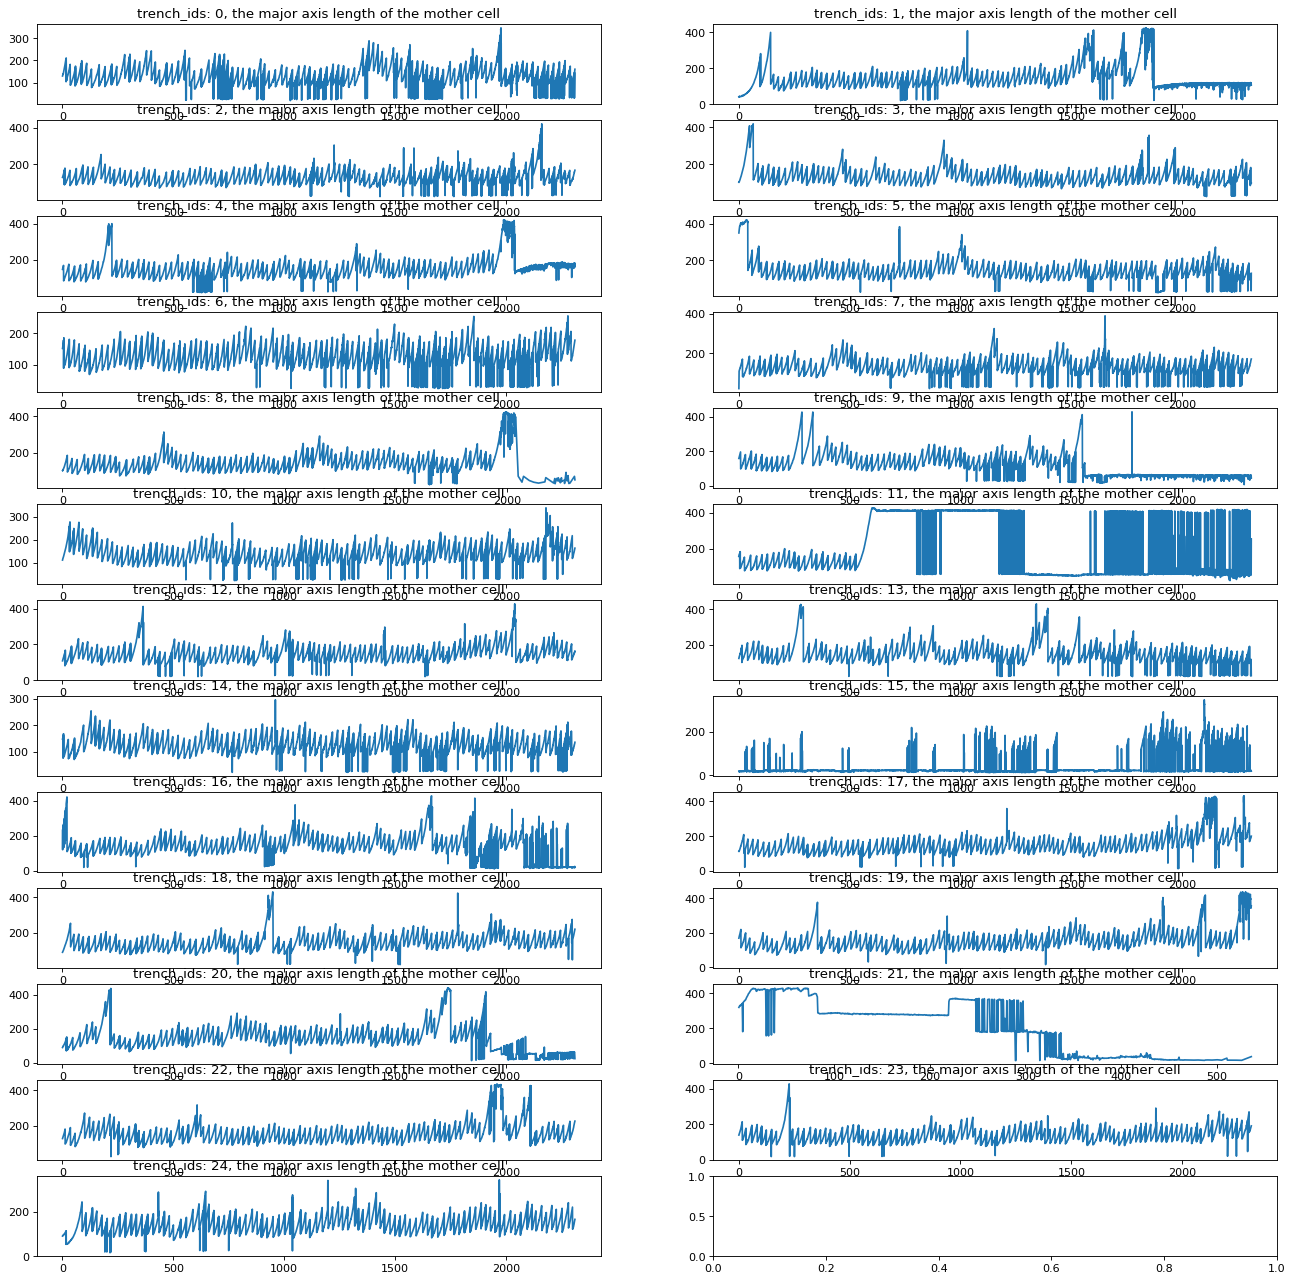

In [84]:
m = exp.get_mother_cell_growth(exp.trenches, plot=True)

In [85]:
props = ["trench_id", "time_(mins)", "label", "major_axis_length"]
mother_df = exp.df.loc[(exp.df["label"] == 1) & (exp.df["time_(mins)"] < 1500) & 
                       (exp.df["trench_id"] != 11) &
                       (exp.df["trench_id"] != 15) &
                       # (exp.df["trench_id"] != 9) &
                       # (exp.df["trench_id"] != 10) &
                       # (exp.df["trench_id"] != 12) &
                       # (exp.df["trench_id"] != 14) &
                       # (exp.df["trench_id"] != 15) &
                       (exp.df["trench_id"] != 21), props].copy()
mother_df.reset_index(drop=True, inplace=True)
display(mother_df.head(6))
trenches_l = mother_df.loc[:, "trench_id"]
trenches_l = sorted(list(set(trenches_l)))
for tr in tqdm(trenches_l):
    mother_cell = mother_df.loc[(mother_df["trench_id"] == tr), 
                              ["major_axis_length"]]
    # print(len(mother_cell))
    growth_r = np.median([np.log(mother_cell["major_axis_length"].iloc[i+1])
                        - np.log(mother_cell["major_axis_length"].iloc[i]) for i in range(1000)])
    # print(growth_r)
    for i in range(len(mother_cell) - 5):
        l1 = mother_cell["major_axis_length"].iloc[i]
        l2 = mother_cell["major_axis_length"].iloc[i + 1]
        l3 = mother_cell["major_axis_length"].iloc[i + 2]
        l4 = mother_cell["major_axis_length"].iloc[i + 3]
        l5 = mother_cell["major_axis_length"].iloc[i + 4]
        l6 = mother_cell["major_axis_length"].iloc[i + 5]
        dlog1 = np.log(l2) - np.log(l1)
        dlog2 = np.log(l3) - np.log(l2)
        dlog3 = np.log(l4) - np.log(l3)
        dlog4 = np.log(l5) - np.log(l4)
        dlog5 = np.log(l6) - np.log(l5)
        if dlog1 < - growth_r:
            if (dlog2 > 5 * growth_r) or (dlog3 > 5 * growth_r) or (dlog4 > 5 * growth_r) or (dlog5 > 5 * growth_r):
                # print(l2)
                # print(mother_df.loc[(mother_df["trench_id"] == tr), 
                #               ["major_axis_length"]].iloc[i + 1])
                # mother_df.loc[(mother_df["trench_id"] == tr), "major_axis_length"].iat[i + 1] = np.exp(growth_r) * l1
                mother_cell["major_axis_length"].iloc[i + 1] = np.exp(growth_r) * l1
                # print(np.exp(growth_r) * l1)
                # print(mother_cell["major_axis_length"].iloc[i + 1])
                # print(mother_df.loc[(mother_df["trench_id"] == tr), 
                #               ["major_axis_length"]].iloc[i + 1])
                # print('correct false div')
            elif (dlog1 < - np.log(4)) and (l2 < 0.3 * np.median(mother_cell["major_axis_length"])):
                # print(np.median(mother_cell["major_axis_length"]))
                mother_cell["major_axis_length"].iloc[i + 1] = np.exp(growth_r) * l1
        elif dlog1 > 5 * growth_r:
            mother_cell["major_axis_length"].iloc[i + 1] = np.exp(growth_r) * l1
            # print('correct joining')
    mother_df.loc[(mother_df["trench_id"] == tr), ["major_axis_length"]] = mother_cell
    # if tr == 0:
    #     mother_df.loc[(mother_df["trench_id"] == tr), 
    #                           ["major_axis_length"]].plot(figsize=(100, 10))
    #     plt.show()
    #     break

# mother_df.to_csv("/home/rl627/SSD1/SB8_30s_230224/short/mother/xy22_mother_length_corrected.csv")

trench_id  time_(mins)  label  major_axis_length
0          0          0.5      1         130.005554
1          0          1.0      1         131.342896
2          0          1.5      1         132.996613
3          0          2.0      1         134.905960
4          0          2.5      1         137.211029
5          0          3.0      1         138.906555

100%|███████████████████████████████████████████| 22/22 [00:02<00:00,  8.52it/s]


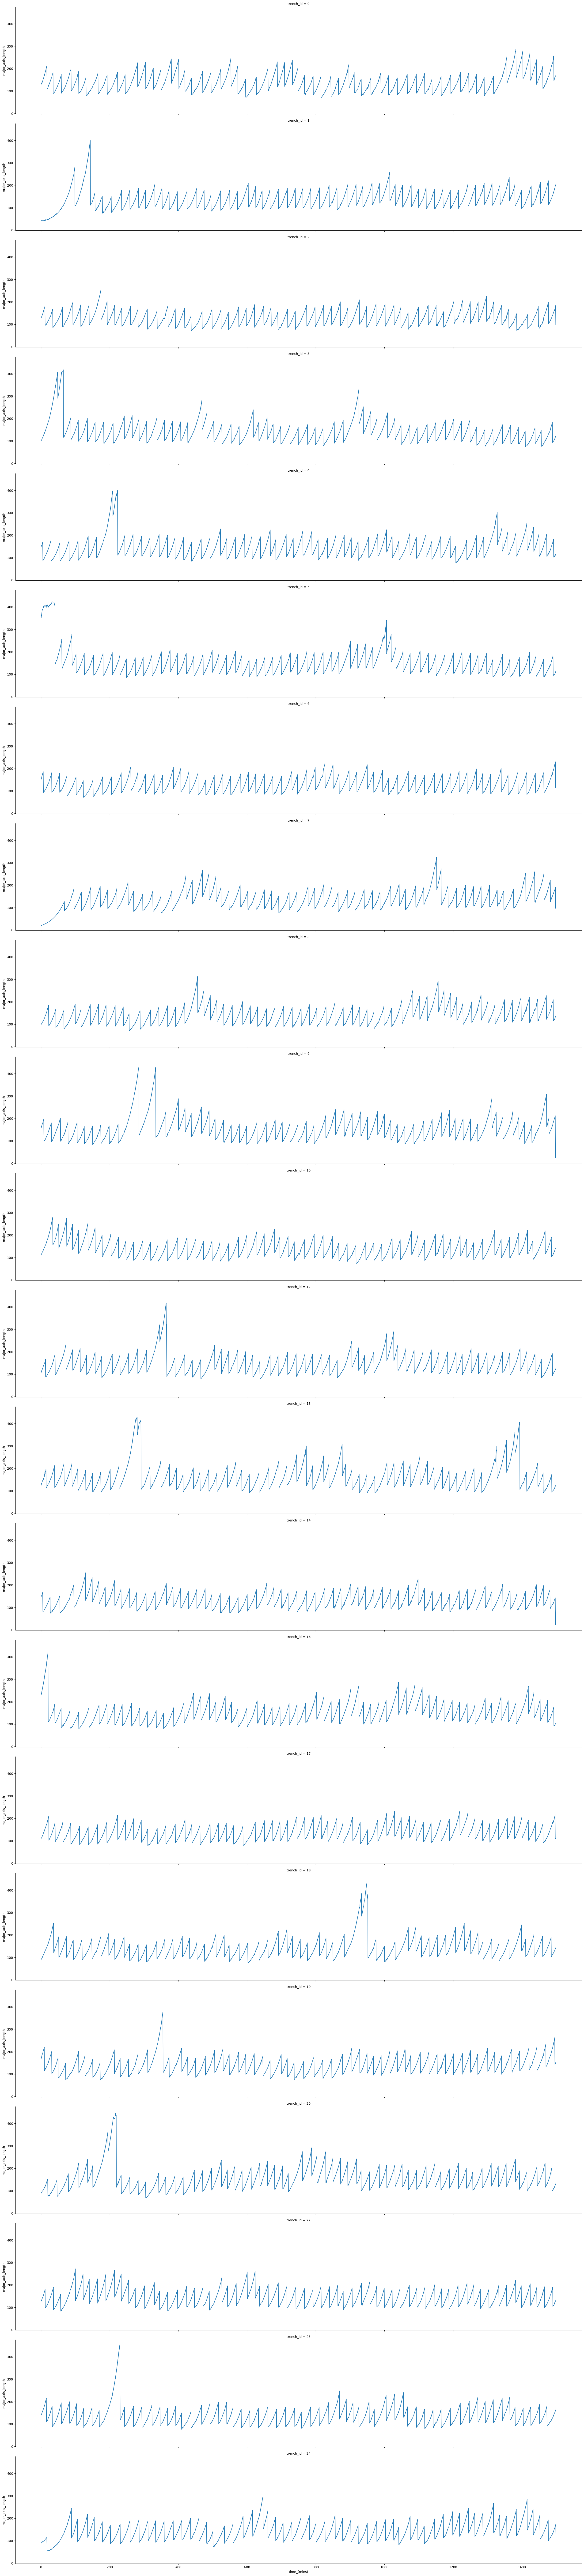

In [86]:
sns.relplot(data = mother_df, x = "time_(mins)", y = "major_axis_length", kind = "line", 
            col = "trench_id", col_wrap = 1, aspect = 5)

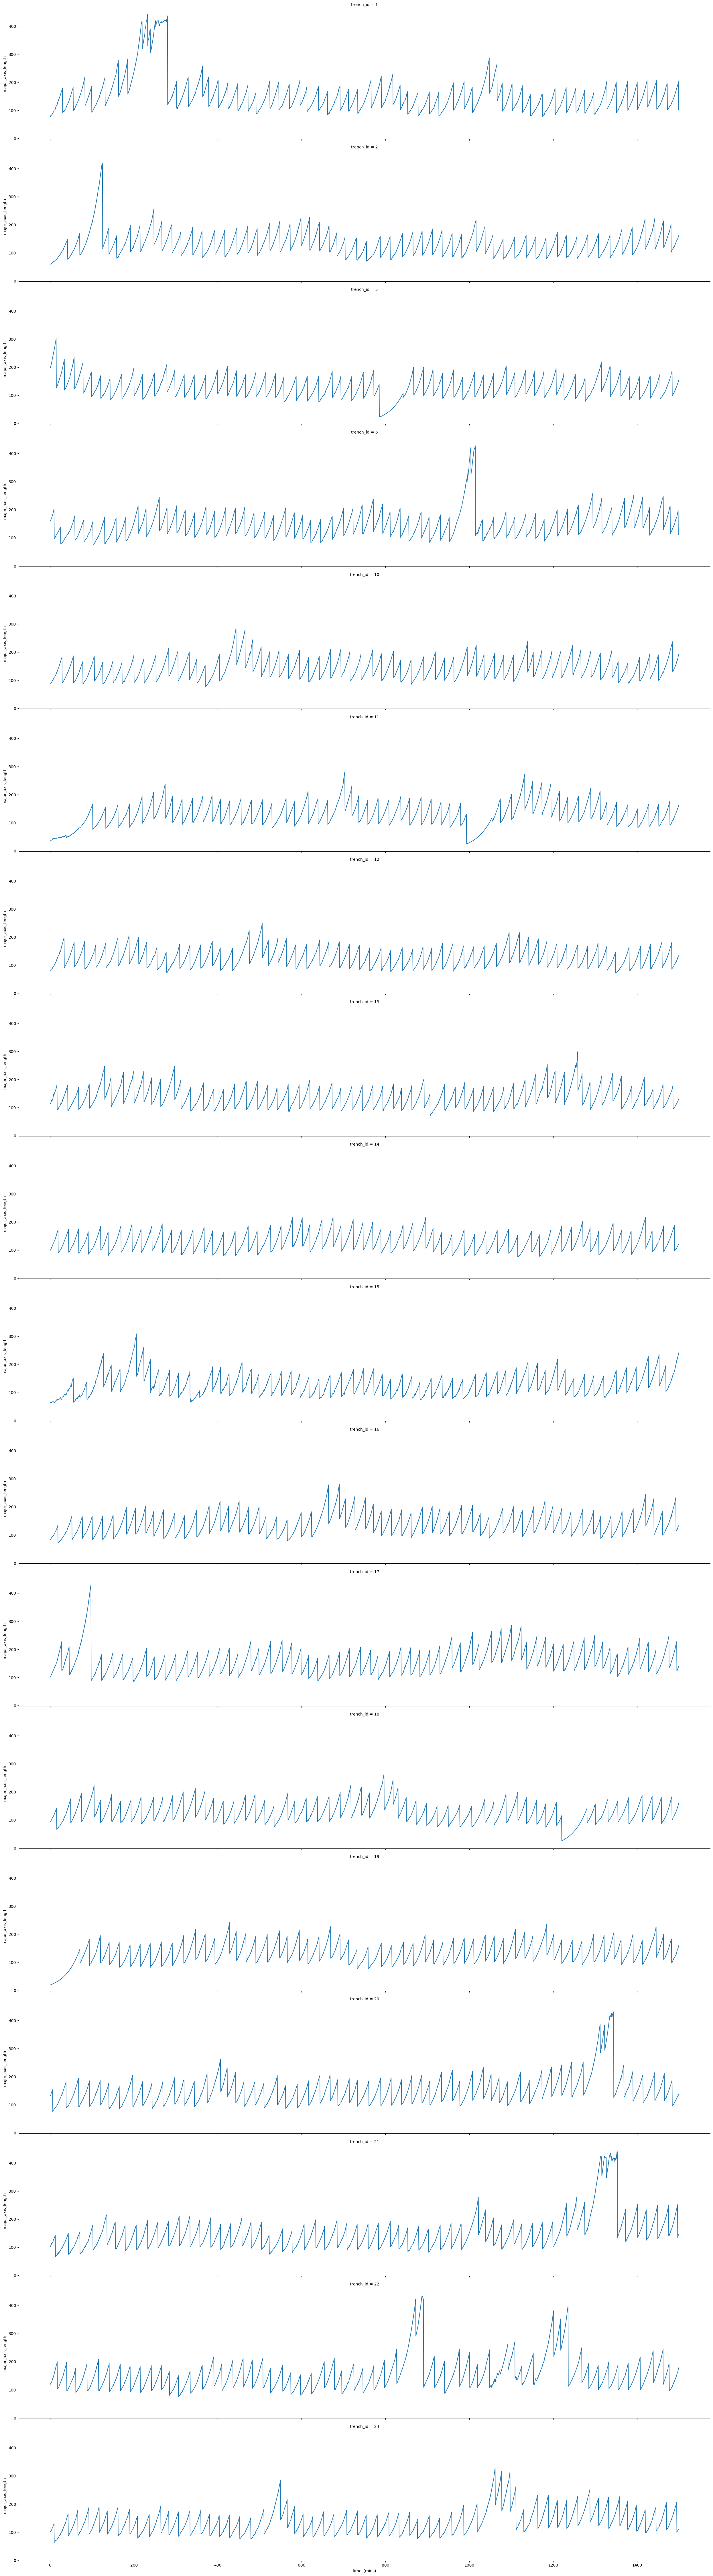

In [51]:
xy15 = pd.read_csv('/home/rl627/SSD1/SB8_30s_230224/short/mother/xy15_mother_length_corrected.csv')
xy20 = pd.read_csv('/home/rl627/SSD1/SB8_30s_230224/short/mother/xy20_mother_length_corrected.csv')
xy21 = pd.read_csv('/home/rl627/SSD1/SB8_30s_230224/short/mother/xy21_mother_length_corrected.csv')
xy22 = pd.read_csv('/home/rl627/SSD1/SB8_30s_230224/short/mother/xy22_mother_length_corrected.csv')
sns.relplot(data = xy20, x = "time_(mins)", y = "major_axis_length", kind = "line", 
            col = "trench_id", col_wrap = 1, aspect = 5)
# sns.set(rc={'figure.figsize':(200, 10)})

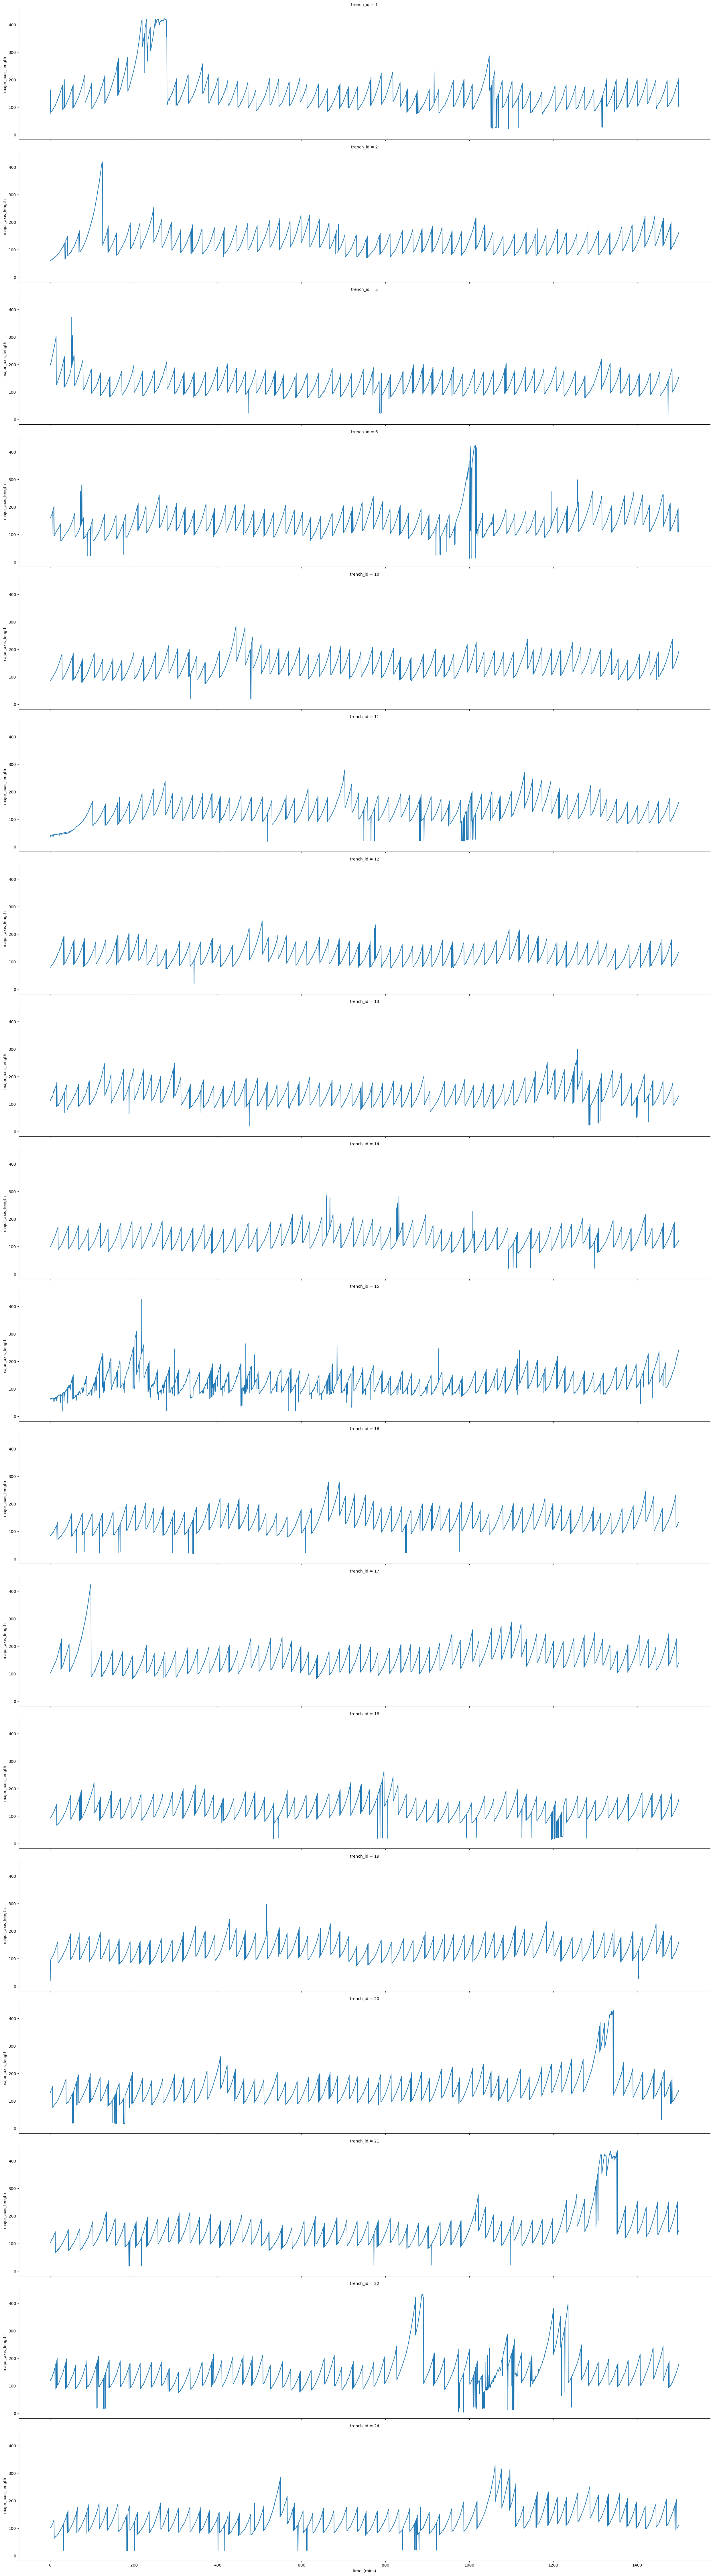

In [35]:
mother_df2 = exp.df.loc[(exp.df["label"] == 1) & (exp.df["time_(mins)"] < 1500) & 
                       (exp.df["trench_id"] != 0) &
                       (exp.df["trench_id"] != 3) &
                       (exp.df["trench_id"] != 4) &
                       (exp.df["trench_id"] != 7) &
                       (exp.df["trench_id"] != 8) &
                       (exp.df["trench_id"] != 23) &
                       (exp.df["trench_id"] != 9), props].copy()
sns.relplot(data = mother_df2, x = "time_(mins)", y = "major_axis_length", kind = "line", 
            col = "trench_id", col_wrap = 1, aspect = 5)

100%|███████████████████████████████████████████| 22/22 [00:02<00:00, 10.79it/s]


0.04609175870858114


100%|███████████████████████████████████████████| 22/22 [00:01<00:00, 21.70it/s]


0.0331490034030141


100%|███████████████████████████████████████████| 22/22 [00:00<00:00, 33.12it/s]


0.02208835341365462


100%|███████████████████████████████████████████| 22/22 [00:00<00:00, 44.25it/s]


0.017730928588837437


100%|███████████████████████████████████████████| 22/22 [00:00<00:00, 53.88it/s]


0.015329469188529591


100%|███████████████████████████████████████████| 22/22 [00:00<00:00, 64.92it/s]


0.00998900293255132


100%|███████████████████████████████████████████| 22/22 [00:00<00:00, 75.78it/s]


0.010374331550802139


100%|███████████████████████████████████████████| 22/22 [00:00<00:00, 86.51it/s]


0.01078167115902965


100%|███████████████████████████████████████████| 22/22 [00:00<00:00, 96.77it/s]


0.008264462809917356


100%|██████████████████████████████████████████| 22/22 [00:00<00:00, 106.55it/s]


0.008292383292383292


100%|██████████████████████████████████████████| 22/22 [00:00<00:00, 117.18it/s]


0.006252112200067591


100%|██████████████████████████████████████████| 22/22 [00:00<00:00, 126.88it/s]


0.007021433850702144


100%|██████████████████████████████████████████| 22/22 [00:00<00:00, 135.05it/s]


0.006407689227072487


100%|██████████████████████████████████████████| 22/22 [00:00<00:00, 144.73it/s]


0.004093063334769496


100%|██████████████████████████████████████████| 22/22 [00:00<00:00, 154.60it/s]


0.0027829313543599257


100%|██████████████████████████████████████████| 22/22 [00:00<00:00, 159.81it/s]


0.0009881422924901185


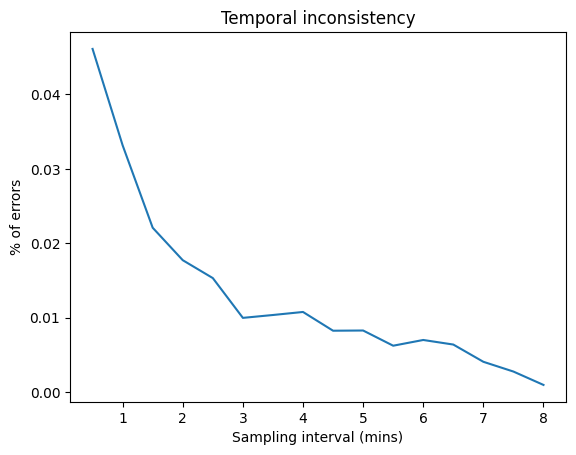

In [89]:
hysteresis = []
for step in range(1, 17):
    props = ["trench_id", "time_(mins)", "label", "major_axis_length"]
    mother_df = exp.df.loc[(exp.df["label"] == 1) & (exp.df["time_(mins)"] < 1500) & 
                           (exp.df["trench_id"] != 11) &
                           (exp.df["trench_id"] != 21) &
                           (exp.df["trench_id"] != 15) &
                           (exp.df["time_(mins)"] % (0.5 * step) == 0), props].copy()
    mother_df.reset_index(drop=True, inplace=True)
    # display(mother_df.head(6))
    trenches_l = mother_df.loc[:, "trench_id"]
    trenches_l = sorted(list(set(trenches_l)))
    count = 0
    total = 0
    for tr in tqdm(trenches_l):
        mother_cell = mother_df.loc[(mother_df["trench_id"] == tr), 
                                  ["major_axis_length"]]
        # print(len(mother_cell))
        growth_r = np.median([np.log(mother_cell["major_axis_length"].iloc[i+1])
                            - np.log(mother_cell["major_axis_length"].iloc[i]) for i in range(int(1500/step))])
        # print(growth_r)
        for i in range(len(mother_cell) - 3):
            total += 1
            l1 = mother_cell["major_axis_length"].iloc[i]
            l2 = mother_cell["major_axis_length"].iloc[i + 1]
            l3 = mother_cell["major_axis_length"].iloc[i + 2]
            l4 = mother_cell["major_axis_length"].iloc[i + 3]
            dlog1 = np.log(l2) - np.log(l1)
            dlog2 = np.log(l3) - np.log(l2)
            dlog3 = np.log(l4) - np.log(l3)
            if dlog1 < - growth_r:
                if dlog2 > 10 * growth_r or dlog3 > 10 * growth_r:

                    count += 1
                    mother_cell["major_axis_length"].iloc[i + 1] = np.exp(growth_r) * l1

            elif dlog1 > 10 * growth_r:
                count += 1
                mother_cell["major_axis_length"].iloc[i + 1] = np.exp(growth_r) * l1
                # print('correct joining')
        mother_df.loc[(mother_df["trench_id"] == tr), ["major_axis_length"]] = mother_cell

    count = count / total
    print(count)
    
    hysteresis.append(count)
plt.title("Temporal inconsistency")
plt.plot(0.5 * np.arange(1, 17), hysteresis)
plt.xlabel("Sampling interval (mins)")
plt.ylabel("% of errors")
plt.show()